## VAE outlier detection for income prediction

### Method

The Variational Auto-Encoder ([VAE](https://arxiv.org/abs/1312.6114)) outlier detector is first trained on a batch of unlabeled, but normal (inlier) data. Unsupervised training is desireable since labeled data is often scarce. The VAE detector tries to reconstruct the input it receives. If the input data cannot be reconstructed well, the reconstruction error is high and the data can be flagged as an outlier. The reconstruction error is measured as the mean squared error (MSE) between the input and the reconstructed instance.

### Dataset

The instances contain a person's characteristics like age, marital status or education while the label represents whether the person makes more or less than $50k per year. The dataset consists of a mixture of numerical and categorical features. It is originally not an outlier detection dataset so we will inject artificial outliers. It is fetched using the [Alibi](https://github.com/SeldonIO/alibi) library, which can be installed with pip: 

```bash
pip install alibi
```

In [1]:
import alibi
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Dense, InputLayer

from alibi_detect.od import OutlierVAE
from alibi_detect.utils.perturbation import inject_outlier_tabular
from alibi_detect.utils.saving import save_detector, load_detector
from alibi_detect.utils.visualize import plot_instance_score

In [2]:
def set_seed(s=0):
    np.random.seed(s)
    tf.random.set_seed(s)

## Load adult dataset

The ```fetch_adult``` function returns a ```Bunch``` object containing the features, the targets, the feature names and a mapping of the categories in each categorical variable.

In [3]:
adult = alibi.datasets.fetch_adult()
X, y = adult.data, adult.target
feature_names = adult.feature_names
category_map_tmp = adult.category_map

Shuffle data:

In [4]:
set_seed(0)
Xy_perm = np.random.permutation(np.c_[X, y])
X, y = Xy_perm[:,:-1], Xy_perm[:,-1]

Reorganize data so categorical features come first, remove some features and adjust ```feature_names``` and ```category_map``` accordingly:

In [5]:
keep_cols = [2, 3, 5, 0, 8, 9, 10]
feature_names = feature_names[2:4] + feature_names[5:6] + feature_names[0:1] + feature_names[8:11]
print(feature_names)

['Education', 'Marital Status', 'Relationship', 'Age', 'Capital Gain', 'Capital Loss', 'Hours per week']


In [6]:
X = X[:, keep_cols]
print(X.shape)

(32561, 7)


In [7]:
category_map = {}
i = 0
for k, v in category_map_tmp.items():
    if k in keep_cols:
        category_map[i] = v
        i += 1

## Preprocess data

Normalize numerical features or scale numerical between -1 and 1:

In [8]:
minmax = False

In [9]:
X_num = X[:, -4:].astype(np.float32, copy=False)
if minmax:
    xmin, xmax = X_num.min(axis=0), X_num.max(axis=0)
    rng = (-1., 1.)
    X_num_scaled = (X_num - xmin) / (xmax - xmin) * (rng[1] - rng[0]) + rng[0]
else:  # normalize
    mu, sigma = X_num.mean(axis=0), X_num.std(axis=0)
    X_num_scaled = (X_num - mu) / sigma

Fit OHE to categorical variables:

In [10]:
X_cat = X[:, :-4].copy()
ohe = OneHotEncoder(categories='auto')
ohe.fit(X_cat)

OneHotEncoder(categorical_features=None, categories='auto', drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='error',
              n_values=None, sparse=True)

Combine numerical and categorical data:

In [11]:
X = np.c_[X_cat, X_num_scaled].astype(np.float32, copy=False)

Define train, validation (to find outlier threshold) and test set:

In [12]:
n_train = 25000
n_valid = 5000
X_train, y_train = X[:n_train,:], y[:n_train]
X_valid, y_valid = X[n_train:n_train+n_valid,:], y[n_train:n_train+n_valid]
X_test, y_test = X[n_train+n_valid:,:], y[n_train+n_valid:]
print(X_train.shape, y_train.shape, 
      X_valid.shape, y_valid.shape,
      X_test.shape, y_test.shape)

(25000, 7) (25000,) (5000, 7) (5000,) (2561, 7) (2561,)


## Create outliers

Inject outliers in the numerical features. First we need to know the features for each kind:

In [13]:
cat_cols = list(category_map.keys())
num_cols = [col for col in range(X.shape[1]) if col not in cat_cols]
print(cat_cols, num_cols)

[0, 1, 2] [3, 4, 5, 6]


### Numerical

Now we can add outliers to the validation (or threshold) and test sets. For the numerical data, we need to specify the numerical columns (```cols```), the percentage of outliers (```perc_outlier```), the strength (```n_std```) and the minimum size of the perturbation (```min_std```). The outliers are distributed evenly across the numerical features:

In [14]:
perc_outlier = 10
data = inject_outlier_tabular(X_valid, num_cols, perc_outlier, n_std=8., min_std=6.)
X_threshold, y_threshold = data.data, data.target
X_threshold_, y_threshold_ = X_threshold.copy(), y_threshold.copy()  # store for comparison later
outlier_perc = 100 * y_threshold.sum() / len(y_threshold)
print('{:.2f}% outliers'.format(outlier_perc))

9.58% outliers


Let's inspect an instance that was changed:

In [15]:
outlier_idx = np.where(y_threshold != 0)[0]
vdiff = X_threshold[outlier_idx[0]] - X_valid[outlier_idx[0]]
fdiff = np.where(vdiff != 0)[0]
print('{} changed by {:.2f}.'.format(feature_names[fdiff[0]], vdiff[fdiff[0]]))

Capital Loss changed by -6.27.


Same thing for the test set:

In [16]:
data = inject_outlier_tabular(X_test, num_cols, perc_outlier, n_std=8., min_std=6.)
X_outlier, y_outlier = data.data, data.target
print('{:.2f}% outliers'.format(100 * y_outlier.sum() / len(y_outlier)))

9.49% outliers


## Apply one-hot encoding

OHE to train, threshold and outlier sets:

In [17]:
X_train_ohe = ohe.transform(X_train[:, :-4].copy())
X_threshold_ohe = ohe.transform(X_threshold[:, :-4].copy())
X_outlier_ohe = ohe.transform(X_outlier[:, :-4].copy())
print(X_train_ohe.shape, X_threshold_ohe.shape, X_outlier_ohe.shape)

(25000, 17) (5000, 17) (2561, 17)


In [18]:
X_train = np.c_[X_train_ohe.todense(), X_train[:, -4:]].astype(np.float32, copy=False)
X_threshold = np.c_[X_threshold_ohe.todense(), X_threshold[:, -4:]].astype(np.float32, copy=False)
X_outlier = np.c_[X_outlier_ohe.todense(), X_outlier[:, -4:]].astype(np.float32, copy=False)
print(X_train.shape, X_threshold.shape, X_outlier.shape)

(25000, 21) (5000, 21) (2561, 21)


## Load or define outlier detector

The pretrained outlier and adversarial detectors used in the example notebooks can be found [here](https://console.cloud.google.com/storage/browser/seldon-models/alibi-detect). You can either manually download the relevant files in the [od_vae_adult](https://console.cloud.google.com/storage/browser/seldon-models/alibi-detect/od_vae_adult/) folder to e.g. the local directory ```my_dir```. Alternatively, if you have [Google Cloud SDK](https://cloud.google.com/sdk/docs/) installed, you can download the whole folder as follows:


```bash
!gsutil cp -r gs://seldon-models/alibi-detect/od_vae_kddcup my_dir
```

In [19]:
load_outlier_detector = False

In [20]:
filepath = './models/od_vae_adult/'  # change to directory where model is downloaded
if load_outlier_detector:  # load pretrained outlier detector
    od = load_detector(filepath)
else:  # define model, initialize, train and save outlier detector
    n_features = X_train.shape[1]
    latent_dim = 2

    encoder_net = tf.keras.Sequential(
      [
          InputLayer(input_shape=(n_features,)),
          Dense(25, activation=tf.nn.relu),
          Dense(10, activation=tf.nn.relu),
          Dense(5, activation=tf.nn.relu)
      ])

    decoder_net = tf.keras.Sequential(
      [
          InputLayer(input_shape=(latent_dim,)),
          Dense(5, activation=tf.nn.relu),
          Dense(10, activation=tf.nn.relu),
          Dense(25, activation=tf.nn.relu),
          Dense(n_features, activation=None)
      ])
    
    # initialize outlier detector
    od = OutlierVAE(threshold=None,  # threshold for outlier score
                    score_type='mse',  # use MSE of reconstruction error for outlier detection
                    encoder_net=encoder_net,  # can also pass VAE model instead
                    decoder_net=decoder_net,  # of separate encoder and decoder
                    latent_dim=latent_dim,
                    samples=5)
    
    # train
    od.fit(X_train,
           loss_fn=tf.keras.losses.mse,
           epochs=5,
           verbose=True)

    # save the trained outlier detector
    save_detector(od, filepath)

391/391 [=] - 4s 10ms/step - loss: 0.2893


The warning tells us we still need to set the outlier threshold. This can be done with the ```infer_threshold``` method. We need to pass a batch of instances and specify what percentage of those we consider to be normal via ```threshold_perc```.

In [21]:
od.infer_threshold(X_threshold, threshold_perc=100-outlier_perc, outlier_perc=100)
print('New threshold: {}'.format(od.threshold))

New threshold: 1.584931560587883


Let’s save the outlier detector with updated threshold:

In [22]:
save_detector(od, filepath)

## Detect outliers

In [23]:
od_preds = od.predict(X_outlier,
                      outlier_type='instance',
                      return_feature_score=True,
                      return_instance_score=True)

## Display results

F1 score and confusion matrix:

F1 score: 0.88 -- Accuracy: 0.98 -- Precision: 0.90 -- Recall: 0.87


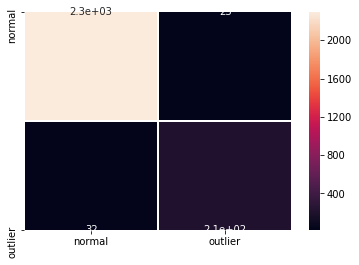

In [24]:
labels = data.target_names
y_pred = od_preds['data']['is_outlier']
f1 = f1_score(y_outlier, y_pred)
acc = accuracy_score(y_outlier, y_pred)
prec = precision_score(y_outlier, y_pred)
rec = recall_score(y_outlier, y_pred)
print('F1 score: {:.2f} -- Accuracy: {:.2f} -- Precision: {:.2f} -- Recall: {:.2f}'.format(f1, acc, prec, rec))
cm = confusion_matrix(y_outlier, y_pred)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
sns.heatmap(df_cm, annot=True, cbar=True, linewidths=.5)
plt.show()

Plot instance level outlier scores vs. the outlier threshold:

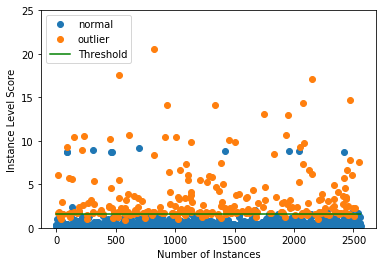

In [25]:
plot_instance_score(od_preds, y_outlier.astype(int), labels, od.threshold, ylim=(0, 25))